# Housekeeping

In [157]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Data Gathering, Generating Features, Creating Train-Test Split

In [158]:

def get_data():
    Vol_Index = yf.download("^VIX", auto_adjust=True, period='20y')["Close"]
    SPY = yf.download("SPY", auto_adjust=True, period='20y')["Close"]
    SH = yf.download("SH", auto_adjust=True, period='20y')["Close"]
    VolVol_Index = yf.download("^VVIX", auto_adjust=True, period='20y')["Close"]
    TenYearTNote = yf.download("^TNX", auto_adjust=True, period='20y')["Close"]

    df = pd.concat([Vol_Index, SPY, SH, VolVol_Index, TenYearTNote], axis=1)
    df.columns = ['Vol_Index', 'SPY', 'SH', 'VolVol_Index', 'TenYearTNote']
    return df.dropna()


def get_features(df):
    # Daily Returns
    df['VIX_ret_1d'] = df['Vol_Index'].pct_change()
    df['SPY_ret_1d'] = df['SPY'].pct_change()
    df['SH_ret_1d'] = df['SH'].pct_change()  # Add SH return

    # Technical Indicators for VIX
    df['VIX_SMA20'] = df['Vol_Index'].rolling(20).mean() #Indicates if VIX is elevated or depressed
    df['VIX_ratio'] = df['Vol_Index'] / df['VIX_SMA20'] #Suggests that VIX might be high compared to recent history if greater than 1 
    df['VIX_std20'] = df['Vol_Index'].rolling(20).std() #Measures the volatility of its volatility, higher values might imply whether VIX is unstable or erratic

    # Spread Features
    df['VIX_VVIX_spread'] = df['Vol_Index'] - df['VolVol_Index']  #Spread between VIX and VVIX, larger spread often precedes spikes in market fear
    df['TNX_ret_1d'] = df['TenYearTNote'].pct_change()  #10yr treasury yield return - Captures Macro Sentiment 

    # Will VIX Rise Tomorrow?
    df['VIX_direction'] = (df['Vol_Index'].shift(-1) > df['Vol_Index']).astype(int) #Predicting whether VIX will increase using above features

    return df.dropna()


def get_features_train_test_split(df):
    features = ['VIX_ret_1d', 'SPY_ret_1d', 'VIX_ratio', 'VIX_std20', 'VIX_VVIX_spread', 'TNX_ret_1d']
    input_data = df[features].dropna()
    target_variable = df.loc[input_data.index, 'VIX_direction']

    X_train, X_test, y_train, y_test = train_test_split(input_data, target_variable, train_size=0.8, shuffle=False)
    return X_train, X_test, y_train, y_test

# Training Model, Summarising Performance 

In [159]:
def train_model(X_train, y_train):
    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    return model


def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    return y_pred, y_proba


def model_performance_summary(y_test, y_pred):
    report = classification_report(y_test, y_pred, output_dict=True)

    print("=== Model Classification Report ===")
    print(classification_report(y_test, y_pred))
    print(f"• Overall accuracy: {report['accuracy']:.2%}\n")

    for cls in ['0', '1']:
        precision = report[cls]['precision']
        recall = report[cls]['recall']
        f1 = report[cls]['f1-score']
        support = report[cls]['support']

        if cls == '0':
            print("• Class '0' (VIX does NOT rise next day):")
        else:
            print("• Class '1' (VIX RISES next day):")

        print(f"  - Precision: {precision:.2%} (Correctness of predictions)")
        print(f"  - Recall: {recall:.2%} (How many actual cases identified)")
        print(f"  - F1-score: {f1:.2%} (Balance of precision & recall)")
        print(f"  - Sample count: {support}\n")



def plot_classification_report(y_test, y_pred):
    from sklearn.metrics import classification_report
    report = classification_report(y_test, y_pred, output_dict=True)
    classes = ['0', '1']
    
    headers = ["Class", "Precision", "Recall", "F1-Score", "Support"]
    rows = []
    for cls in classes:
        rows.append([
            f"Class {cls}",
            f"{report[cls]['precision']:.2%}",
            f"{report[cls]['recall']:.2%}",
            f"{report[cls]['f1-score']:.2%}",
            f"{int(report[cls]['support'])}"
        ])

    fig, ax = plt.subplots(figsize=(6, 2))
    ax.axis('tight')
    ax.axis('off')
    table_data = [headers] + rows
    table = ax.table(cellText=table_data, loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)
    plt.title("Classification Report Summary")
    plt.show()



def plot_confusion_matrix(y_test, y_pred):
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    labels = ['Predicted 0', 'Predicted 1']

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Normalized Confusion Matrix (Row-wise)")
    plt.show()

# Calibrating to Find the Optimal Strategy

In [160]:
def find_best_threshold(df, X_test, y_proba):
    df = df.copy()
    df['SPY_ret_1d'] = df['SPY'].pct_change()
    thresholds = np.arange(0.3, 0.6, 0.025)
    returns = []

    for t in thresholds:
        df['position'] = 0
        df.loc[X_test.index, 'position'] = np.where(y_proba > t, 1, -1)
        df['strategy_ret'] = df['position'].shift(1) * df['SPY_ret_1d']
        cumulative = (1 + df['strategy_ret']).cumprod()
        returns.append(cumulative.dropna().iloc[-1])

    plt.figure(figsize=(10, 2))
    sns.heatmap([returns], xticklabels=[f"{th:.3f}" for th in thresholds], cmap="RdYlGn", annot=True, fmt=".4f")
    plt.title("Strategy Final Returns by Threshold")
    plt.xlabel("Threshold")
    plt.yticks([], [])
    plt.show()

    best_idx = np.argmax(returns)
    best_threshold = thresholds[best_idx]
    print(f"Best threshold found: {best_threshold:.3f} with final return {returns[best_idx]:.4f}\n")
    return best_threshold

def backtest_strategy(df, X_test, y_proba, threshold):
    df = df.copy()
    df['SPY_ret'] = df['SPY'].pct_change()
    start_date = X_test.index[0]
    df = df.loc[start_date:]

    df['position'] = 0
    df.loc[X_test.index, 'position'] = np.where(y_proba > threshold, 1, -1)

    df['strategy_ret'] = df['position'].shift(1) * df['SPY_ret']
    df['cumulative_strategy'] = (1 + df['strategy_ret']).cumprod()
    df['cumulative_spy'] = (1 + df['SPY_ret']).cumprod()
    return df

def plot_backtest_results(df):
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['cumulative_strategy'], label='Strategy', color='dodgerblue', linewidth=2)
    plt.plot(df.index, df['cumulative_spy'], label='SPY (Buy & Hold)', color='orange', linewidth=2)

    macro_events = {
        "2022-01-24": "Tech Drawdown",
        "2022-03-16": "1st Fed Hike",
        "2022-06-13": "CPI Shock",
        "2022-09-21": "Dot Plot Surprise",
        "2022-10-13": "CPI Reversal",
        "2023-03-10": "SVB Collapse",
        "2023-10-19": "10Y @ 5%",
        "2024-03-20": "No Rate Cut",
        "2024-07-05": "NFP Beat",
        "2024-11-05": "Election Volatility",
        "2025-02-01": "China Crash",
        "2025-04-07": "Tariff Bear Market",
        "2025-07-21": "Profit Shock Report"
    }

    ymax = max(df['cumulative_strategy'].max(), df['cumulative_spy'].max())
    for date_str, label in macro_events.items():
        date = pd.to_datetime(date_str)
        if date in df.index:
            plt.axvline(x=date, color='black', linestyle='dotted', linewidth=1)
            plt.text(date, ymax * 1.02, label, rotation=90, verticalalignment='bottom', fontsize=9)

    plt.title("Cumulative Returns: Macro Strategy vs SPY")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.tight_layout()
    plt.show()


# Summarising Performance, Running Code

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


=== Model Classification Report ===
              precision    recall  f1-score   support

           0       0.57      0.91      0.70       528
           1       0.48      0.11      0.18       400

    accuracy                           0.56       928
   macro avg       0.53      0.51      0.44       928
weighted avg       0.53      0.56      0.48       928

• Overall accuracy: 56.47%

• Class '0' (VIX does NOT rise next day):
  - Precision: 57.43% (Correctness of predictions)
  - Recall: 90.72% (How many actual cases identified)
  - F1-score: 70.34% (Balance of precision & recall)
  - Sample count: 528.0

• Class '1' (VIX RISES next day):
  - Precision: 47.87% (Correctness of predictions)
  - Recall: 11.25% (How many actual cases identified)
  - F1-score: 18.22% (Balance of precision & recall)
  - Sample count: 400.0



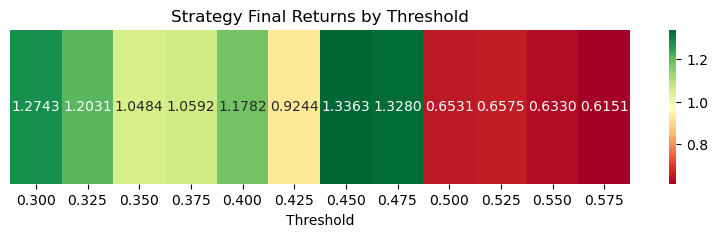

Best threshold found: 0.450 with final return 1.3363



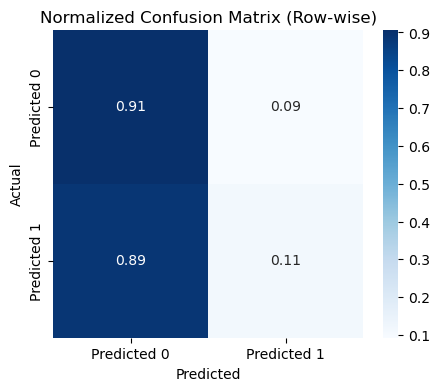

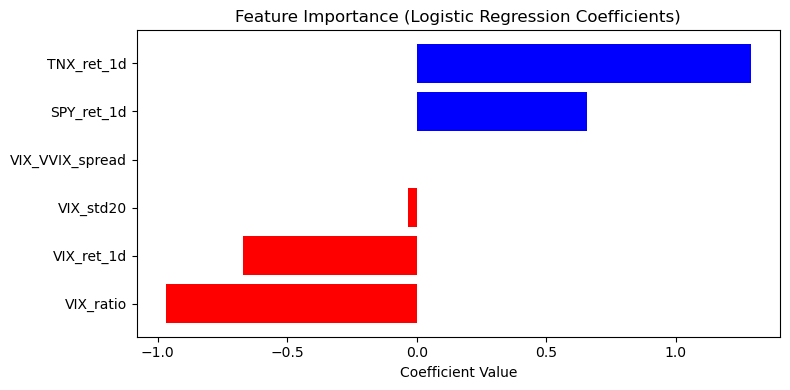

=== Strategy Performance Summary ===
Total Return: 33.63%
Annualized Return (CAGR): 8.20%
Sharpe Ratio (annualized): 0.52
Max Drawdown: -17.60%

SPY Total Return (Buy & Hold): 42.66%
SPY Annualized Return (CAGR): 10.14%
SPY Sharpe Ratio (annualized): 0.62
SPY Max Drawdown: -24.50%


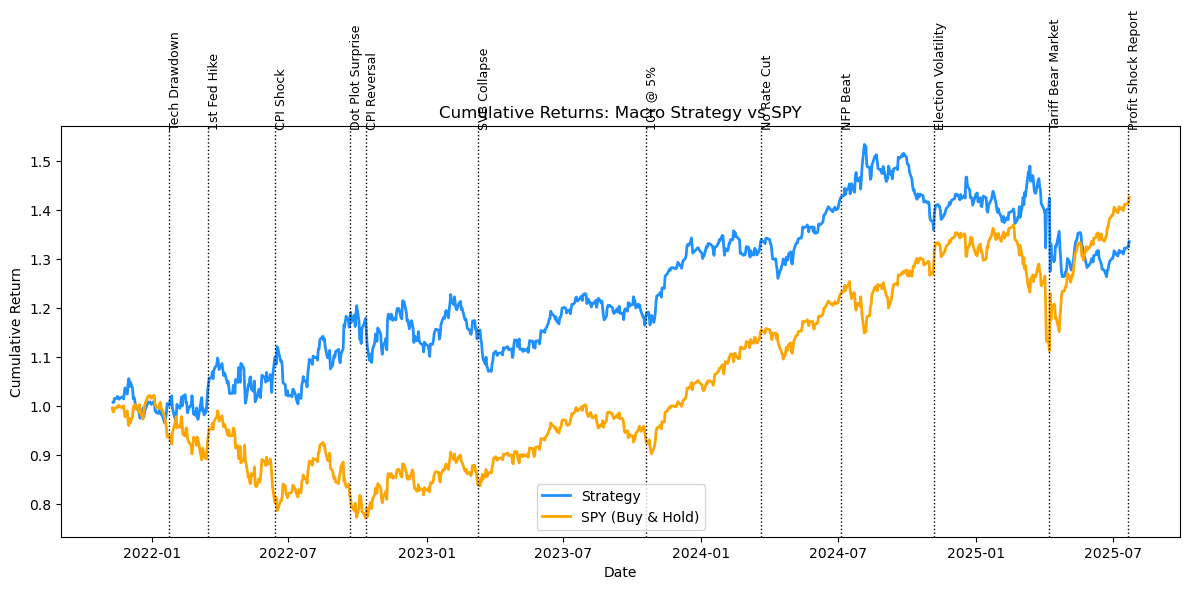

In [161]:
def strategy_performance_summary(df):
    cumulative_return = df['cumulative_strategy'].iloc[-1] - 1
    total_days = len(df.dropna())
    annual_factor = 252

    annualized_return = (df['cumulative_strategy'].iloc[-1]) ** (annual_factor / total_days) - 1
    strat_ret = df['strategy_ret'].dropna()
    sharpe_ratio = strat_ret.mean() / strat_ret.std() * np.sqrt(annual_factor)

    running_max = df['cumulative_strategy'].cummax()
    drawdown = (df['cumulative_strategy'] - running_max) / running_max
    max_drawdown = drawdown.min()

    spy_return = df['cumulative_spy'].iloc[-1] - 1
    spy_cagr = df['cumulative_spy'].iloc[-1] ** (annual_factor / total_days) - 1
    spy_ret = df['SPY'].pct_change()
    spy_sharpe = spy_ret.mean() / spy_ret.std() * np.sqrt(annual_factor)

    spy_running_max = df['cumulative_spy'].cummax()
    spy_drawdown = (df['cumulative_spy'] - spy_running_max) / spy_running_max
    spy_max_drawdown = spy_drawdown.min()

    print("=== Strategy Performance Summary ===")
    print(f"Total Return: {cumulative_return*100:.2f}%")
    print(f"Annualized Return (CAGR): {annualized_return*100:.2f}%")
    print(f"Sharpe Ratio (annualized): {sharpe_ratio:.2f}")
    print(f"Max Drawdown: {max_drawdown*100:.2f}%\n")
    print(f"SPY Total Return (Buy & Hold): {spy_return*100:.2f}%")
    print(f"SPY Annualized Return (CAGR): {spy_cagr*100:.2f}%")
    print(f"SPY Sharpe Ratio (annualized): {spy_sharpe:.2f}")
    print(f"SPY Max Drawdown: {spy_max_drawdown*100:.2f}%")

def plot_feature_importance_logreg(model, feature_names):
    coefs = model.coef_[0]
    df_imp = pd.DataFrame({
        "Feature": feature_names,
        "Coefficient": coefs
    }).sort_values(by="Coefficient")
    
    colors = ['blue' if x > 0 else 'red' for x in df_imp['Coefficient']]

    plt.figure(figsize=(8, max(4, 0.3 * len(df_imp))))
    plt.barh(df_imp['Feature'], df_imp['Coefficient'], color=colors)
    plt.xlabel("Coefficient Value")
    plt.title("Feature Importance (Logistic Regression Coefficients)")
    plt.tight_layout()
    plt.show()

def main():
    df = get_data()
    df = get_features(df)

    X_train, X_test, y_train, y_test = get_features_train_test_split(df)
    feature_names = X_train.columns.tolist()
    model = train_model(X_train, y_train)
    y_pred, y_proba = evaluate_model(model, X_test, y_test)

    model_performance_summary(y_test, y_pred)
    best_threshold = find_best_threshold(df, X_test, y_proba)

    plot_confusion_matrix(y_test, y_pred)
    plot_feature_importance_logreg(model, feature_names)

    backtest_df = backtest_strategy(df, X_test, y_proba, best_threshold)
    strategy_performance_summary(backtest_df)
    plot_backtest_results(backtest_df)

main()